# ML Project - Binary Classification - **Marcos García Estévez**

The goal of this project is to develop a machine learning model using a classification algorithm to predict the probability of hard disk drive (HDD) failures in the near future. This prediction will be based on SMART (Self-Monitoring, Analysis, and Reporting Technology) data and other key features, such as brand and storage capacity.

**Project Explanation Video (Spanish):** https://www.youtube.com/watch?v=jqhft3HSQkY

However, please note that the values shown in the video are different, as it was based on the initial trial. The models and code in this notebook are from the second version, with improved values.

<img src="https://www.backblaze.com/blog/wp-content/uploads/2019/11/blog-Drive-Purchasing-Philosophy-1.jpg" alt="Backblaze Logo" width="500">

## **Step 0: Required Imports and Installations**

In [2]:
!pip install tqdm
!pip install groq
!pip install -q gdown

import os
import re
import shutil
import time
import random
import pickle
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import gdown

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from zipfile import ZipFile
from IPython.display import display, HTML
from tqdm import tqdm
from groq import Groq, GroqError

## **Step 1: Data Collection**

In this first step, I will download the datasets in .zip format and extract them to facilitate easier access to their CSV files.

### **Step 1.1:** Download .zip and Consolidate.
I will download the data (zip) for 2018 to the first two quarters of 2024 and consolidate them into a single folder.

In [40]:
# URLs de los dataset (2024-2018) en .zip
urls = {
    "Q2_2024": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2024.zip",
    "Q1_2024": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2024.zip",
    "Q1_2023": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2023.zip",
    "Q2_2023": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2023.zip",
    "Q3_2023": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2023.zip",
    "Q4_2023": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2023.zip",
    "Q4_2022": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2022.zip",
    "Q3_2022": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2022.zip",
    "Q2_2022": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2022.zip",
    "Q1_2022": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2022.zip",
    "Q4_2021": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2021.zip",
    "Q3_2021": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2021.zip",
    "Q2_2021": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2021.zip",
    "Q1_2021": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2021.zip",
    "Q4_2020": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2020.zip",
    "Q3_2020": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2020.zip",
    "Q2_2020": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2020.zip",
    "Q1_2020": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2020.zip",
    "Q4_2019": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2019.zip",
    "Q3_2019": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2019.zip",
    "Q2_2019": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2019.zip",
    "Q1_2019": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2019.zip",
    "Q4_2018": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2018.zip",
    "Q3_2018": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2018.zip",
    "Q2_2018": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2018.zip",
    "Q1_2018": "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2018.zip"
}

# Descargar y extraer cada archivo .zip
for folder_name, url in urls.items():
    zip_path = f"{folder_name}.zip"  # Nombre temporal del archivo .zip
    # Descargar el .zip desde la URL
    with open(zip_path, "wb") as f:
        f.write(requests.get(url).content)
    # Extraer el .zip en una carpeta con el nombre adecuado
    with ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(folder_name)
    os.remove(zip_path)  # Eliminar el .zip después de extraerlo

# Crear la carpeta 'Todos_CSV' para almacenar todos los archivos CSV
todos_csv_folder = "Todos_CSV"
os.makedirs(todos_csv_folder, exist_ok=True)

# Mover todos los archivos CSV a 'Todos_CSV' y eliminar las carpetas originales
for folder_name in urls.keys():
    for root, _, files in os.walk(folder_name):
        for file in files:
            if file.endswith(".csv"):  # Filtrar solo archivos CSV
                shutil.move(os.path.join(root, file), todos_csv_folder)
    shutil.rmtree(folder_name)  # Eliminar la carpeta original

print("Todos los archivos CSV han sido agrupados en 'Todos_CSV'. Puedes pasar a la siguiente celda.")

Todos los archivos CSV han sido agrupados en 'Todos_CSV'. Puedes pasar a la siguiente celda.


### **Step 1.2:** Columns.

Now let's look at the columns in the CSV files. There are quite a few, so I will display them in a more horizontal format.

In [42]:
# Cargar el archivo CSV para ver sus columnas
example_csv = "Todos_CSV/2024-01-01.csv"
df = pd.read_csv(example_csv)

# Definir el número de columnas a mostrar por fila - valor ajustable
cols_per_row = 8

# Crear una lista de filas de columnas
columns = list(df.columns)
rows = [columns[i:i + cols_per_row] for i in range(0, len(columns), cols_per_row)]

# Generar un fragmentillo HTML para la visualización en formato horizontal
html_code = "<table style='border-collapse: collapse; width: 100%;'>"
for row in rows:
    html_code += "<tr>"
    for col in row:
        html_code += f"<td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>{col}</td>"
    html_code += "</tr>"
html_code += "</table>"

# Mostrar el HTML
display(HTML(html_code))

date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id,vault_id
pod_id,pod_slot_num,is_legacy_format,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized
smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized
smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized
smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized
smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized
smart_24_raw,smart_27_normalized,smart_27_raw,smart_71_normalized,smart_71_raw,smart_82_normalized,smart_82_raw,smart_90_normalized
smart_90_raw,smart_160_normalized,smart_160_raw,smart_161_normalized,smart_161_raw,smart_163_normalized,smart_163_raw,smart_164_normalized
smart_164_raw,smart_165_normalized,smart_165_raw,smart_166_normalized,smart_166_raw,smart_167_normalized,smart_167_raw,smart_168_normalized
smart_168_raw,smart_169_normalized,smart_169_raw,smart_170_normalized,smart_170_raw,smart_171_normalized,smart_171_raw,smart_172_normalized
smart_172_raw,smart_173_normalized,smart_173_raw,smart_174_normalized,smart_174_raw,smart_175_normalized,smart_175_raw,smart_176_normalized


## **Step 2: Handling Class Imbalance**


I used a dataset provided by Backblaze, which includes detailed information about their hard drives in use within their data centers, accessible via [this link](https://www.backblaze.com/cloud-storage/resources/hard-drive-test-data). The dataset contains the following information:

- **Date** – The file date (when the data was recorded) in yyyy-mm-dd format.
- **Serial Number** – The serial number of the hard drive.
- **Model** – The model number of the hard drive.
- **Capacity** – The storage capacity of the drive in bytes.
- **Failure** – Binary value, with 0 indicating the drive is operational, or 1 if it is the last day the drive was operational before failing.
- **SMART** – Since 2018, the SMART data provided by Backblaze includes 124 columns, which are the raw and normalized values of the 62 different SMART statistics reported by the drive. For specific information on each SMART column, refer to [this Wikipedia page](https://en.wikipedia.org/wiki/Self-Monitoring,_Analysis_and_Reporting_Technology).

Backblaze provides data on a daily basis, generating a CSV each day with the collected information. These daily files are then grouped quarterly, which is when they are published.

However, the dataset exhibits a significant imbalance between non-failing drives (`failure = 0`) and failing drives (`failure = 1`), which could bias the model. As we’ll see in the next cell, each day around 8-13 drives fail, while over 280,000 continue to operate.

### **Step 2.1:** Daily Failures.

First, let's review 5 random CSV files to see how many drives typically fail on those days. We’ll also remove any ._ CSV files that don't add value (these usually contain metadata and are randomly selected, causing errors).

This information on daily failures will highlight the need for more data on a drive's values before failure. Only having about 10 rows is insufficient for training a binary classifier.

In [44]:
# Definir la carpeta donde están los archivos CSV
csv_folder = "Todos_CSV"

# Eliminar archivos que comienzan con "._"
for file in os.listdir(csv_folder):
    if file.startswith("._") and file.endswith(".csv"):
        os.remove(os.path.join(csv_folder, file))

# Listar todos los archivos CSV restantes en la carpeta
csv_files = [f for f in os.listdir(csv_folder) if f.endswith(".csv")]

# Seleccionar 5 archivos aleatorios de la lista
selected_files = random.sample(csv_files, 5)

# Iterar sobre cada archivo seleccionado y contar filas con failure == TRUE
for file in selected_files:
    file_path = os.path.join(csv_folder, file)
    df = pd.read_csv(file_path)

    # Contar filas donde 'failure' es True
    failure_count = df[df['failure'] == True].shape[0]

    # Extraer la fecha del nombre del archivo
    match = re.search(r'\d{4}-\d{2}-\d{2}', file)
    date = match.group(0) if match else "Fecha desconocida"

    print(f"{failure_count} discos duros fallaron el día {date} (archivo: {file})")

7 discos duros fallaron el día 2023-09-27 (archivo: 2023-09-27.csv)
6 discos duros fallaron el día 2021-02-06 (archivo: 2021-02-06.csv)
3 discos duros fallaron el día 2021-03-26 (archivo: 2021-03-26.csv)
13 discos duros fallaron el día 2022-05-05 (archivo: 2022-05-05.csv)
6 discos duros fallaron el día 2020-02-15 (archivo: 2020-02-15.csv)


### **Step 2.2:** Grouping Failures

Next, we’ll perform the following:

- A script that iterates through all the CSV files (all except the last one), extracting only the drives that failed. This way, we capture the rows with the final values of each drive before it failed.
- The resulting CSV, filled with failed drives, will then be combined with the last CSV (June 30th), which will serve as my final dataset for analysis. This helps to somewhat balance the dataset, though it remains imbalanced. I considered using SMOTE, but for now, I’ll proceed with training and, based on the results, decide on the next steps.

In [45]:
# Definir la carpeta de los CSV y el archivo de exclusión
csv_folder = "Todos_CSV"
exclude_file = "2024-06-30.csv"
output_file = os.path.join(csv_folder, "CSV_FALLOS.csv")

# Crear un DataFrame vacío para almacenar las filas con fallos
all_failures = pd.DataFrame()

# Listar todos los archivos CSV excepto el excluido
csv_files = [f for f in os.listdir(csv_folder) if f.endswith(".csv") and f != exclude_file]

# Iterar sobre los archivos CSV con barra de progreso
for file in tqdm(csv_files, desc="Procesando archivos CSV"):
    file_path = os.path.join(csv_folder, file)
    df = pd.read_csv(file_path, encoding='latin1')

    # Filtrar filas donde 'failure' es True
    failures = df[df['failure'] == True]

    # Añadir los fallos al DataFrame acumulado
    all_failures = pd.concat([all_failures, failures], ignore_index=True)

# Guardar todas las filas con fallos en un nuevo archivo CSV
all_failures.to_csv(output_file, index=False)

# Eliminar todos los archivos CSV excepto el de exclusión
for file in csv_files:
    os.remove(os.path.join(csv_folder, file))

print(f"Todas las filas con 'failure = True' se han guardado en {output_file} y se han eliminado los CSV originales (excepto {exclude_file}).")

Procesando archivos CSV: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2372/2372 [40:14<00:00,  1.02s/it]


Todas las filas con 'failure = True' se han guardado en Todos_CSV/CSV_FALLOS.csv y se han eliminado los CSV originales (excepto 2024-06-30.csv).


### **Step 2.3:** Merging CSVs

Now that we have a CSV (CSV_failures.csv) with a lot more data on the values of drives before they failed, we can add these rows to the CSV from June 30. This will give us a slightly more balanced dataset.

Next, we’ll print the number of failed drives (now that we’ve merged the files) and the percentage they represent, to get an idea of the remaining imbalance.

Finally, we’ll shuffle the CSV and name it "dataset.csv," moving it out of the folder and into the root directory.

In [46]:
# Definir carpetas y archivos a utilizar
csv_folder = "Todos_CSV"
failures_csv = os.path.join(csv_folder, "CSV_FALLOS.csv")
main_csv = os.path.join(csv_folder, "2024-06-30.csv")

# Cargar ambos datasets
df_failures = pd.read_csv(failures_csv)
df_main = pd.read_csv(main_csv)

# Fusionar los datasets (añadir filas de fallos al CSV del 30 de junio)
df_combined = pd.concat([df_main, df_failures], ignore_index=True)

# Contar el número total de discos y los que fallaron
total_disks = df_combined.shape[0]
failed_disks = df_combined[df_combined['failure'] == True].shape[0]
failure_percentage = (failed_disks / total_disks) * 100

# Imprimir el número de discos que fallaron y el porcentaje
print(f"Total de discos: {total_disks}")
print(f"Discos rotos: {failed_disks}")
print(f"Porcentaje de discos rotos: {failure_percentage:.2f}%")

# Barajar el dataset para equilibrarlo y guardar como "dataset.csv" en el directorio raíz
df_shuffled = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.to_csv("dataset.csv", index=False)

# Mover el archivo final al directorio raíz
shutil.move("dataset.csv", "dataset.csv")
print("El archivo final (pre-limpieza) 'dataset.csv' ha sido creado y movido al directorio raíz.")

Total de discos: 306001
Discos rotos: 16967
Porcentaje de discos rotos: 5.54%
El archivo final (pre-limpieza) 'dataset.csv' ha sido creado y movido al directorio raíz.


We can see that there are around 17,000 failed drives, making up about ~5.54% of the total dataset. We’ll leave it as it is for now and revisit after cleaning to see how it looks, as well as evaluate the model’s performance post-training.

## **Step 3: Data Cleaning and Preprocessing**

As we've been observing, the dataset is very comprehensive. However, it requires some cleaning to be genuinely useful. For example, certain SMART attribute columns are empty (some drives may not support all sensors, or some may be specific to a particular manufacturer). Therefore, we need to clean these columns/rows based on the number of missing attributes. Alternatively, we could fill these values with the mean/median; though with such a large dataset, it may be better to remove them.

In summary, to prepare the dataset for model training, I will conduct the following cleaning and preprocessing steps:

- **Remove Irrelevant Columns**:
   - The columns `serial_number`, `datacenter`, `cluster_id`, `vault_id`, `pod_id`, `pod_slot_num`, and `is_legacy_format` will be removed, as they hold little relevance for prediction.
   - The `date` column will also be removed, as it only indicates when the data was recorded and does not provide predictive information on drive failure.

- **Selection of SMART Values**:
   - I will remove the "raw" values of SMART attributes, retaining only the "normalized" values, which are more consistent and less dependent on the manufacturer.
   - I will prioritize certain SMART attributes, discarding others that do not contribute relevant information on the health of a drive. This will help reduce noise and speed up training.

- **Capacity Normalization**:
   - Finally, I will normalize the `capacity_bytes` column to prevent its scale from disproportionately influencing the model. I will convert it to terabytes.

### **Step 3.1:** Remove Irrelevant Columns

As mentioned, we will remove the `date`, `serial_number`, `datacenter`, `cluster_id`, `vault_id`, `pod_id`, `pod_slot_num`, and `is_legacy_format` columns.

Additionally, we will remove columns containing unnormalized SMART values (raw).

In [47]:
# Cargar el dataset
file_path = 'dataset.csv'
df = pd.read_csv(file_path)

# Eliminar las columnas especificadas
columns_to_drop = [
    'date', 'serial_number', 'datacenter', 'cluster_id',
    'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format'
]
df = df.drop(columns=columns_to_drop)

# Eliminar las columnas RAW de los atributos SMART
raw_columns = [col for col in df.columns if '_raw' in col]
df = df.drop(columns=raw_columns)

# Guardar el dataset procesado como un nuevo archivo
output_path = 'dataset_3_1.csv'
df.to_csv(output_path, index=False)

# Verificación final: Mostrar las primeras filas del dataset procesado
print("Columnas especificadas y atributos RAW eliminados correctamente.")
print("Primeras filas del dataset limpio:")
print(df.head())

Columnas especificadas y atributos RAW eliminados correctamente.
Primeras filas del dataset limpio:
                 model  capacity_bytes  failure  smart_1_normalized  \
0        ST16000NM001G    1.600090e+13        0                73.0   
1  WDC WUH722222ALE6L4    2.200097e+13        0               100.0   
2        ST12000NM0008    1.200014e+13        0                82.0   
3  TOSHIBA MG08ACA16TA    1.600090e+13        0               100.0   
4        ST12000NM001G    1.200014e+13        0                83.0   

   smart_2_normalized  smart_3_normalized  smart_4_normalized  \
0                 NaN                98.0               100.0   
1               148.0                83.0               100.0   
2                 NaN                90.0               100.0   
3               100.0               100.0               100.0   
4                 NaN                97.0               100.0   

   smart_5_normalized  smart_7_normalized  smart_8_normalized  ...  \
0           

As we can see, although the data is in better shape, there are still many empty values in certain columns. This is what we will address next.

### **Step 3.2:** SMART Values

We will print the percentage of empty cells for each normalized SMART value. The goal is to keep only the SMART values with around a maximum of 5-10% missing values and remove rows that contain empty attributes.

This way, we avoid adding noise, as would happen if we filled in missing values with the mean/median, and removing a few rows won’t have a significant impact given the dataset's large size.

In [48]:
# Cargar el dataset
df = pd.read_csv("dataset_3_1.csv")

# Lista de columnas SMART relevantes
smart_normalized_columns = [
    'smart_1_normalized', 'smart_2_normalized', 'smart_3_normalized', 'smart_4_normalized',
    'smart_5_normalized', 'smart_7_normalized', 'smart_8_normalized', 'smart_9_normalized',
    'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_13_normalized',
    'smart_15_normalized', 'smart_16_normalized', 'smart_17_normalized', 'smart_18_normalized',
    'smart_22_normalized', 'smart_23_normalized', 'smart_24_normalized', 'smart_27_normalized',
    'smart_71_normalized', 'smart_82_normalized', 'smart_90_normalized', 'smart_160_normalized',
    'smart_161_normalized', 'smart_163_normalized', 'smart_164_normalized', 'smart_165_normalized',
    'smart_166_normalized', 'smart_167_normalized', 'smart_168_normalized', 'smart_169_normalized',
    'smart_170_normalized', 'smart_171_normalized', 'smart_172_normalized', 'smart_173_normalized',
    'smart_174_normalized', 'smart_175_normalized', 'smart_176_normalized', 'smart_177_normalized',
    'smart_178_normalized', 'smart_179_normalized', 'smart_180_normalized', 'smart_181_normalized',
    'smart_182_normalized', 'smart_183_normalized', 'smart_184_normalized', 'smart_187_normalized',
    'smart_188_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_191_normalized',
    'smart_192_normalized', 'smart_193_normalized', 'smart_194_normalized', 'smart_195_normalized',
    'smart_196_normalized', 'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized',
    'smart_200_normalized', 'smart_201_normalized', 'smart_202_normalized', 'smart_206_normalized',
    'smart_210_normalized', 'smart_218_normalized', 'smart_220_normalized', 'smart_222_normalized',
    'smart_223_normalized', 'smart_224_normalized', 'smart_225_normalized', 'smart_226_normalized',
    'smart_230_normalized', 'smart_231_normalized', 'smart_232_normalized', 'smart_233_normalized',
    'smart_234_normalized', 'smart_235_normalized', 'smart_240_normalized', 'smart_241_normalized',
    'smart_242_normalized', 'smart_244_normalized', 'smart_245_normalized', 'smart_246_normalized',
    'smart_247_normalized', 'smart_248_normalized', 'smart_250_normalized', 'smart_251_normalized',
    'smart_252_normalized', 'smart_254_normalized', 'smart_255_normalized'
]

# Total de filas en el dataset para el cálculo del porcentaje
total_rows = df.shape[0]

# Contar columnas SMART vacías (total de valores nulos)
empty_smart_columns = {col: df[col].isnull().sum() for col in smart_normalized_columns}

# Imprimir resultados con número y porcentaje de valores vacíos
for col, empty_count in empty_smart_columns.items():
    empty_percentage = (empty_count / total_rows) * 100  # Calcular el porcentaje
    print(f"Columna {col}: {empty_count} valores vacíos ({empty_percentage:.2f}%)")

Columna smart_1_normalized: 845 valores vacíos (0.28%)
Columna smart_2_normalized: 122786 valores vacíos (40.13%)
Columna smart_3_normalized: 3669 valores vacíos (1.20%)
Columna smart_4_normalized: 3669 valores vacíos (1.20%)
Columna smart_5_normalized: 2448 valores vacíos (0.80%)
Columna smart_7_normalized: 3669 valores vacíos (1.20%)
Columna smart_8_normalized: 122786 valores vacíos (40.13%)
Columna smart_9_normalized: 531 valores vacíos (0.17%)
Columna smart_10_normalized: 3669 valores vacíos (1.20%)
Columna smart_11_normalized: 305424 valores vacíos (99.81%)
Columna smart_12_normalized: 531 valores vacíos (0.17%)
Columna smart_13_normalized: 305899 valores vacíos (99.97%)
Columna smart_15_normalized: 306001 valores vacíos (100.00%)
Columna smart_16_normalized: 304084 valores vacíos (99.37%)
Columna smart_17_normalized: 304084 valores vacíos (99.37%)
Columna smart_18_normalized: 223173 valores vacíos (72.93%)
Columna smart_22_normalized: 225776 valores vacíos (73.78%)
Columna smart_

Here we see some surprising results: there is a high percentage of missing data, and even some columns are **completely** empty, such as smart_250 or smart_251.

Therefore, my approach will be to identify the SMART attributes that most directly indicate disk failures and retain those, along with other relevant attributes that have minimal missing values.

Remember, the explanation of each SMART value can be found on [this Wikipedia page](https://en.wikipedia.org/wiki/Self-Monitoring,_Analysis_and_Reporting_Technology), and values especially relevant for indicating disk failures are marked with a warning triangle.

---

After analyzing the percentage of missing values and reviewing the Wikipedia page on the importance of each metric, I’ve decided it would be best to keep only 13 SMART values, which I will explain in detail later. Additionally, I will extract data on how many rows and the total percentage would need to be removed to ensure there are no nulls in the dataset.


In [3]:
# Cargar el dataset
df = pd.read_csv("dataset_3_1.csv")

# Lista de columnas SMART relevantes filtradas
smart_columns_filtered = [
    'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized',
    'smart_5_normalized', 'smart_7_normalized', 'smart_9_normalized',
    'smart_10_normalized', 'smart_12_normalized', 'smart_192_normalized',
    'smart_193_normalized', 'smart_197_normalized', 'smart_198_normalized',
    'smart_199_normalized'
]

# Total de filas en el dataset
total_rows = df.shape[0]

# Calcular el % de valores nulos en cada columna filtrada
print("Porcentaje de valores vacíos en cada columna:")
for col in smart_columns_filtered:
    empty_count = df[col].isnull().sum()
    empty_percentage = (empty_count / total_rows) * 100
    print(f"Columna {col}: {empty_percentage:.2f}% valores vacíos")

# Calcular el número y porcentaje de filas que deben eliminarse para limpiar los nulos en estas columnas
rows_with_nan = df[smart_columns_filtered].isnull().any(axis=1).sum()
rows_with_nan_percentage = (rows_with_nan / total_rows) * 100

print("\nTotal de filas que deben eliminarse para dejar el dataset sin nulos en las columnas seleccionadas:")
print(f"Filas a eliminar: {rows_with_nan} de {total_rows} ({rows_with_nan_percentage:.2f}%)")

Porcentaje de valores vacíos en cada columna:
Columna smart_1_normalized: 0.28% valores vacíos
Columna smart_3_normalized: 1.20% valores vacíos
Columna smart_4_normalized: 1.20% valores vacíos
Columna smart_5_normalized: 0.80% valores vacíos
Columna smart_7_normalized: 1.20% valores vacíos
Columna smart_9_normalized: 0.17% valores vacíos
Columna smart_10_normalized: 1.20% valores vacíos
Columna smart_12_normalized: 0.17% valores vacíos
Columna smart_192_normalized: 0.54% valores vacíos
Columna smart_193_normalized: 1.32% valores vacíos
Columna smart_197_normalized: 2.92% valores vacíos
Columna smart_198_normalized: 0.90% valores vacíos
Columna smart_199_normalized: 0.80% valores vacíos

Total de filas que deben eliminarse para dejar el dataset sin nulos en las columnas seleccionadas:
Filas a eliminar: 10102 de 306001 (3.30%)


As we can see, removing only about ~3.30% of rows would leave the dataset without any nulls. While we could fill these with the mean/median as mentioned, I don’t believe it’s necessary given the dataset's size.

The 13 SMART values we’ll retain represent the following:

- **smart_1**: Indicator of surface read errors on the disk.
- **smart_3**: Time for the drive head to position correctly.
- **smart_4**: Number of disk start/stop cycles.
- **smart_5**: Count of sectors reassigned due to errors.
- **smart_7**: Number of head seek errors.
- **smart_9**: Total operational time of the disk in hours.
- **smart_10**: Count of failed spin-up attempts.
- **smart_12**: Number of times the disk has been powered on.
- **smart_192**: Count of emergency shutdown events.
- **smart_193**: Head load/unload cycle count.
- **smart_197**: Number of sectors pending reassignment.
- **smart_198**: Count of uncorrectable sectors.
- **smart_199**: UltraDMA CRC interface error count.

Finally, we’ll remove all other SMART values except for the 13 we’re keeping, as well as any rows with at least one null value in these 13 columns (the aforementioned 3.30%).

In [50]:
# Cargar el dataset
file_path = "dataset_3_1.csv"  # Ruta del archivo original
df = pd.read_csv(file_path)

# Lista de columnas SMART específicas que queremos mantener
smart_columns_filtered = [
    'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized',
    'smart_5_normalized', 'smart_7_normalized', 'smart_9_normalized',
    'smart_10_normalized', 'smart_12_normalized', 'smart_192_normalized',
    'smart_193_normalized', 'smart_197_normalized', 'smart_198_normalized',
    'smart_199_normalized'
]

# Seleccionar solo las columnas SMART filtradas y todas las columnas que no empiezan con "smart"
columns_to_keep = smart_columns_filtered + [col for col in df.columns if not col.startswith("smart")]

# Filtrar el dataset para conservar solo las columnas seleccionadas
df_filtered = df[columns_to_keep]

# Eliminar filas con al menos un valor nulo en las 13 columnas SMART seleccionadas
df_filtered = df_filtered.dropna(subset=smart_columns_filtered)

# Guardar el dataset limpio en un nuevo archivo
output_path = "dataset_3_2.csv"
df_filtered.to_csv(output_path, index=False)

print(f"Dataset filtrado y limpio guardado como '{output_path}'")
print(f"Total de filas después de eliminar valores nulos: {df_filtered.shape[0]}")

Dataset filtrado y limpio guardado como 'dataset_3_2.csv'
Total de filas después de eliminar valores nulos: 295899


Lastly, just to **confirm**, we’ll print all columns again in the same horizontal format, as well as the total number of nulls across ALL columns.

In [51]:
# Cargar el dataset completo
file_path = "dataset_3_2.csv"
df = pd.read_csv(file_path)

# Obtener todas las columnas del dataset y contar valores nulos en cada una
columns = df.columns
null_counts = df.isnull().sum()

# Generar el código HTML de la tabla en bloques de 8 columnas
html_code = "<table style='border-collapse: collapse; width: 100%;'>"

# Iterar en bloques de 8 columnas
for i in range(0, len(columns), 8):
    # Agregar nombres de columnas en la primera fila del bloque de 8 columnas
    html_code += "<tr>"
    for col in columns[i:i+8]:  # Seleccionar un bloque de 8 columnas
        html_code += f"<th style='border: 1px solid #ddd; padding: 8px; text-align: center;'>{col}</th>"
    html_code += "</tr><tr>"

    # Agregar el total de valores nulos en la segunda fila del bloque de 8 columnas
    for col in columns[i:i+8]:  # Seleccionar un bloque de 8 columnas
        html_code += f"<td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>{null_counts[col]}</td>"
    html_code += "</tr>"

html_code += "</table>"

# Mostrar el código HTML generado
from IPython.core.display import display, HTML
display(HTML(html_code))

/tmp/ipykernel_10004/1049408682.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized
0,0,0,0,0,0,0,0
smart_192_normalized,smart_193_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,model,capacity_bytes,failure
0,0,0,0,0,0,0,0


As we can see, there are no nulls in any of the columns. We have completed this step and are ready to move on to the next.


## **Step 4: Scaling `capacity_bytes` & Removing SSDs**

First, in this step, we will focus on scaling the capacity column. The issue is that this column presents data in bytes, which is a very large value, and if left as it is, the model might overly rely on it for making predictions.

Let's check the first 5 values to see this visually.

In [52]:
# Cargar el dataset
file_path = "dataset_3_2.csv"
df = pd.read_csv(file_path)

# Imprimir los primeros valores de la columna 'capacity_bytes'
if 'capacity_bytes' in df.columns:
    print("Primeros 5 valores de 'capacity_bytes':")
    print(df['capacity_bytes'].head())

Primeros 5 valores de 'capacity_bytes':
0    1.600090e+13
1    2.200097e+13
2    1.200014e+13
3    1.600090e+13
4    1.200014e+13
Name: capacity_bytes, dtype: float64


As we can see, the value is in bytes. To address this, we’ll convert these values to TB by dividing by 1e12 and rounding to 2 decimal places (Backblaze has some drives with capacities under 1 TB).

Additionally, we’ll save this in a new column (`capacity_terabytes`) and remove the original column in bytes.

In [53]:
# Cargar el dataset
file_path = "dataset_3_2.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    raise FileNotFoundError(f"No se encontró el archivo '{file_path}'. Verifica la ruta.")

# Validar la presencia de la columna 'capacity_bytes'
if 'capacity_bytes' not in df.columns:
    raise ValueError("'capacity_bytes' no está presente en el dataset. Algo ha ido mal.")

# Convertir 'capacity_bytes' de bytes a terabytes y verificar valores nulos
df['capacity_terabytes'] = df['capacity_bytes'] / 1e12
df['capacity_terabytes'] = df['capacity_terabytes'].round(2) # Redondear a 2 decimales

# Validar que no haya valores nulos en 'capacity_terabytes'
if df['capacity_terabytes'].isnull().any():
    raise ValueError("Se encontraron valores nulos en 'capacity_terabytes' después de la conversión. Revisa los datos de entrada.")

# Eliminar la columna original 'capacity_bytes'
df = df.drop(columns=['capacity_bytes'])

# Guardar el dataset con la columna convertida a terabytes
output_path = "dataset_4.csv"
try:
    df.to_csv(output_path, index=False)
    print(f"Dataset guardado como '{output_path}' con 'capacity_terabytes' redondeado y sin 'capacity_bytes'.")
except Exception as e:
    raise IOError(f"Error al guardar el archivo '{output_path}': {e}")


Dataset cargado correctamente.
Dataset guardado como 'dataset_4.csv' con 'capacity_terabytes' redondeado y sin 'capacity_bytes'.


Now, to verify everything went smoothly, we’ll print 10 random values from `capacity_terabytes`.

In [54]:
# Cargar el dataset
file_path = "dataset_4.csv"
df = pd.read_csv(file_path)

# Comprobar si la columna 'capacity_terabytes' está presente y mostrar 10 valores aleatorios
if 'capacity_terabytes' in df.columns:
    df['capacity_terabytes'] = df['capacity_terabytes'].astype(float)
    print("10 valores aleatorios de 'capacity_terabytes':")
    print(df['capacity_terabytes'].sample(10))  # Muestra 10 valores aleatorios
else:
    print("La columna 'capacity_terabytes' no está presente en el dataset.")

10 valores aleatorios de 'capacity_terabytes':
77629     14.0
28595     16.0
82937      4.0
186757    14.0
71038     14.0
31870     12.0
180395    14.0
82197     12.0
118751    16.0
220530    12.0
Name: capacity_terabytes, dtype: float64


As we can see, the values have been saved correctly, and we are ready to proceed.

### **Step 4.1:** Removing SSDs

Next, we’ll check how many SSDs or NVMEs are present in our dataset so we can remove them. The reason for this is the significant difference in manufacturing between these two types of storage devices: one has moving parts, while the other does not. Therefore, including SSDs would only add noise to our dataset.

Let’s search our CSV to see how many are present.

Distribución de tipos de disco:
HDD: 295899 discos


/tmp/ipykernel_10004/2742547382.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disk_counts.index, y=disk_counts.values, palette="pastel")


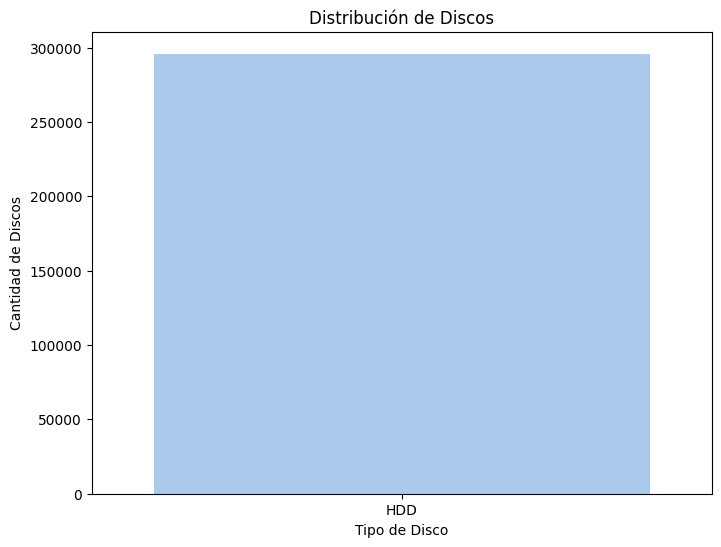

In [55]:
# Cargar el dataset
file_path = "dataset_4.csv"
df = pd.read_csv(file_path)

# Identificar cuántos discos son SSD en base a la columna 'model'
df['disk_type'] = df['model'].apply(lambda x: 'SSD' if 'SSD' in x.upper() or 'NVME' in x.upper() else 'HDD')

# Contar la cantidad de discos
disk_counts = df['disk_type'].value_counts()

# Mostrar los resultados en texto
print("Distribución de tipos de disco:")
for disk_type, count in disk_counts.items():
    print(f"{disk_type}: {count} discos")

# Crear un gráfico de barras para mostrar la distribución de tipos de disco
plt.figure(figsize=(8, 6))
sns.barplot(x=disk_counts.index, y=disk_counts.values, palette="pastel")
plt.title("Distribución de Discos")
plt.xlabel("Tipo de Disco")
plt.ylabel("Cantidad de Discos")
plt.show()

The absence of SSDs, with all drives being HDDs, is a surprise. However, upon reflection, it makes sense.

When we reviewed the SMART values and removed nulls for those 13 selected columns, we also removed the SSDs. This is because SMART attribute #3 measures the time for the drive head to position itself, and since an SSD has no head, it presents a null value in this column.

Thus, by removing rows with null values in that column, we also unintentionally filtered out the SSDs.

With this clarified and verified, we are ready to move on to Step 5.

## **Step 5: Issue with the `model` Column**

This is one of the steps I’ve been most uncertain about—the `model` column, which represents the model of the hard drive. I considered three options for handling it:

- **Keep the column**, which would help the ML model learn the survival rate of each specific drive model (some models may be higher-end and more durable). However, the downside is that the model wouldn’t generalize well to predict failures for drive models not present in the training set, limiting its final utility.
- **Remove the column**, allowing the model to focus primarily on the SMART values and drive capacity (or even removing capacity too and focusing solely on SMART values). The drawback is a potential loss of accuracy, as some drive series are indeed more durable than others.
- **Use a hybrid approach**, which is the option I will go with, consisting of adding a new column, `manufacturer`, with the name of the drive’s manufacturer. Extracting the manufacturer from the model is straightforward, and this way, we retain information on durability by model as it maps to the new `manufacturer` column (different models from the same manufacturer will generally use similar technology).

To perform this mapping from model to manufacturer, I chose an AI-based approach using a LLM, specifically Llama 3.1 70B. This decision was due to the significant time it would take to do it manually.

Finally, lesser-known models that the LLM could not identify will be marked as a generic manufacturer.

### **Step 5.1:** Testing the LLM

First, I will run a quick test call to Llama 3.1 70B using Groq’s free tier to ensure it works correctly and can accurately extract drive manufacturers.

Additionally, we’ll write the prompts in English, as open-source LLMs generally perform best with English inputs.

Note: This cell is not replicable by others, as it calls Groq using an API Key. To replicate it, simply write your own API Key. You can obtain a key [by signing up on their website](https://console.groq.com/); it’s free thanks to their free tier.

In [20]:
# Obtener la clave y pasarla al cliente
api_key = "INSERT_YOUR_KEY_HERE"
client = Groq(api_key=api_key)

chat_completion = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are a hard drive expert."},
        {"role": "user", "content": "Identify the manufacturer for the hard drive model CT250MX500SSD1. Respond with only one word, the manufacturer’s name. No additional information. Use '_' if necessary for spacing. If unsure, respond 'Unknown'."}
    ],
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=25,
    top_p=1,
    stop=None,
    stream=False,
)

# Imprime la respuesta generada por el modelo
print(chat_completion.choices[0].message.content)

Crucial


As we can see, it works correctly. Now, let’s perform one final test by selecting 10 random models from the dataset to ensure that this approach is suitable and accurate. Additionally, we will apply prompt engineering to minimize errors by instructing Llama that it is a hard drive expert and must be as precise as possible.

In [22]:
# Cargar el dataset
file_path = "dataset_4.csv"
df = pd.read_csv(file_path)

# Seleccionar 10 discos (filas) aleatorias
modelos_aleatorios = df['model'].dropna().sample(10).tolist()

# Configurar la clave de la API desde Collab Secrets y cliente de Groq
api_key = "INSERT_YOUR_KEY_HERE"
client = Groq(api_key=api_key)

# Iterar sobre cada modelo aleatorio y llamar a la API de Llama para obtener el fabricante
for modelo in modelos_aleatorios:
    # Crear el mensaje para Llama
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a hard drive expert with extensive knowledge of hard drive manufacturers and models. Always respond concisely and accurately, prioritizing the correct identification of manufacturers."},
            {"role": "user", "content": f"Identify the manufacturer for the hard drive model '{modelo}' with the most accuracy possible. Respond with only one word in lowercase, the manufacturer’s name, using '_' for spacing if required. If you are uncertain, respond exactly as 'unknown' in lowercase without any additional information."}
        ],
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=25,
        top_p=1,
        stop=None,
        stream=False,
    )

    # Obtener y mostrar la respuesta del modelo
    fabricante = chat_completion.choices[0].message.content.strip()
    print(f"Para el modelo '{modelo}', el fabricante es '{fabricante}'.")

Para el modelo 'ST8000NM0055', el fabricante es 'seagate'.
Para el modelo 'TOSHIBA MG08ACA16TA', el fabricante es 'toshiba'.
Para el modelo 'ST12000NM001G', el fabricante es 'seagate'.
Para el modelo 'WDC WUH721414ALE6L4', el fabricante es 'western_digital'.
Para el modelo 'TOSHIBA MG07ACA14TA', el fabricante es 'toshiba'.
Para el modelo 'TOSHIBA MG08ACA16TA', el fabricante es 'toshiba'.
Para el modelo 'TOSHIBA MG08ACA16TA', el fabricante es 'toshiba'.
Para el modelo 'TOSHIBA MG08ACA16TA', el fabricante es 'toshiba'.
Para el modelo 'WDC WUH722222ALE6L4', el fabricante es 'western_digital'.
Para el modelo 'ST14000NM001G', el fabricante es 'seagate'.


### **Step 5.2:** Converting 'model' to 'manufacturer'

Now that we’ve confirmed this LLM-based conversion is fast, robust, and accurate, we can proceed to apply it directly to the CSV.

We’ll use a highly efficient approach: instead of calling Groq for all 280,000+ rows, we’ll create a dictionary to store model-manufacturer pairs. This way, for each row, we’ll check if the model is already in the dictionary; if not, we’ll call Llama and then save the new pair in the dictionary.

Finally, we’ll save the completed dictionary to avoid overwhelming Groq with requests in future runs of this notebook.

In [56]:
# Cargar el dataset
file_path = "dataset_4.csv"
df = pd.read_csv(file_path)

# Configurar la clave de la API desde Collab Secrets y cliente
api_key = "INSERT_YOUR_KEY_HERE"
client = Groq(api_key=api_key)

# Diccionario para almacenar modelos conocidos y sus fabricantes
model_to_manufacturer = {}

# Intentar cargar el diccionario guardado si existe
diccionario_path = "diccionario_modelos.pkl"
try:
    with open(diccionario_path, "rb") as f:
        model_to_manufacturer = pickle.load(f)
    print("Diccionario de modelos cargado desde archivo.")
except FileNotFoundError:
    print("No se encontró un diccionario guardado. Se generará uno nuevo.")

# Nueva columna 'manufacturer' para almacenar los fabricantes obtenidos
manufacturers = []

# Función para llamar a Llama con retry en caso de error
def get_manufacturer_from_llama(modelo):
    retry_count = 0
    while retry_count < 5:
        try:
            chat_completion = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": "You are a hard drive expert with extensive knowledge of hard drive manufacturers and models. Always respond concisely and accurately, prioritizing the correct identification of manufacturers."},
                    {"role": "user", "content": f"Identify the manufacturer for the hard drive model '{modelo}' with the most accuracy possible. Respond with only one word in lowercase, the manufacturer’s name, using '_' for spacing if required. If you are uncertain, respond exactly as 'unknown' in lowercase without any additional information."}
                ],
                model="llama-3.1-70b-versatile",
                temperature=0,
                max_tokens=25,
                top_p=1,
                stop=None,
                stream=False,
            )
            return chat_completion.choices[0].message.content.strip()
        except GroqError as e:
            print(f"Error al llamar a Llama para el modelo '{modelo}': {e}")
            retry_count += 1
            time.sleep(2)  # Espera antes de reintentar
    return "unknown"  # En caso de fallo persistente, asignar "unknown"

# Iterar sobre cada modelo en el dataset con tqdm para mostrar la barra de progreso
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Procesando modelos"):
    modelo = row['model']

    # Verificar si el modelo ya está en el diccionario cargado o en el diccionario generado durante la ejecución
    if modelo in model_to_manufacturer:
        fabricante = model_to_manufacturer[modelo]
    else:
        # Llamar a Llama para obtener el fabricante y actualizar el diccionario
        fabricante = get_manufacturer_from_llama(modelo)
        model_to_manufacturer[modelo] = fabricante
        time.sleep(2)  # Pausa para no exceder el límite de 30 requests por minuto
        # Es decir, no superar el free tier de Groq

    # Agregar el fabricante a la lista de la nueva columna
    manufacturers.append(fabricante)

# Asignar la columna 'manufacturer' al dataframe
df['manufacturer'] = manufacturers

# Verificar que no haya valores nulos en la columna 'manufacturer'
if df['manufacturer'].isnull().sum() == 0:
    # Eliminar la columna 'model'
    df = df.drop(columns=['model'])

    # Guardar el dataset limpio en un nuevo archivo
    output_path = "dataset_5.csv"
    df.to_csv(output_path, index=False)
    print(f"Dataset guardado como '{output_path}' con la columna 'manufacturer' completada y 'model' eliminada.")
else:
    print("Error: Hay valores nulos en la columna 'manufacturer'. Revisa las llamadas a Llama.")

# Guardar el diccionario de modelos y fabricantes actualizado en un archivo pickle
with open(diccionario_path, "wb") as f:
    pickle.dump(model_to_manufacturer, f)

print(f"Diccionario de modelos y fabricantes guardado como '{diccionario_path}'.")

Diccionario de modelos cargado desde archivo.


Procesando modelos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295899/295899 [00:24<00:00, 11871.72it/s]


Dataset guardado como 'dataset_5.csv' con la columna 'manufacturer' completada y 'model' eliminada.
Diccionario de modelos y fabricantes guardado como 'diccionario_modelos.pkl'.


### **Step 5.3:** Manufacturer Distribution and Corrections

To wrap up this step, and mostly out of curiosity, let’s see how many manufacturers Backblaze uses in total and the percentage of drives they have from each manufacturer.

It’s worth noting that this won’t be entirely precise, as we previously deleted several rows with null values.

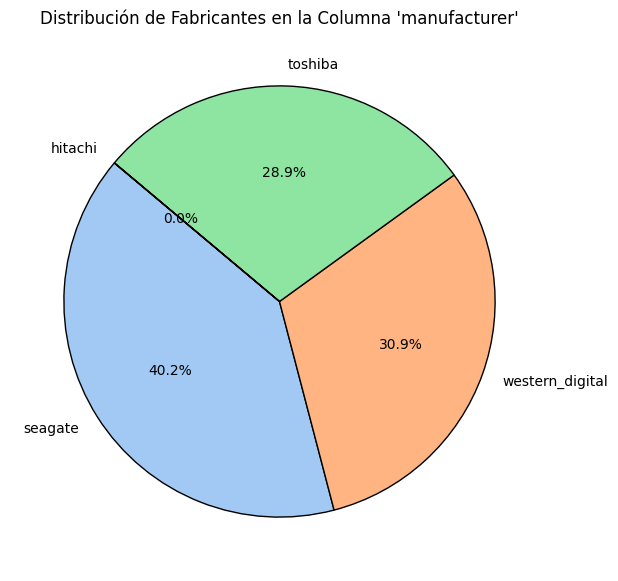

In [57]:
# Cargar el dataset
file_path = "dataset_5.csv"
df = pd.read_csv(file_path)

# Contar la frecuencia de cada fabricante en la columna 'manufacturer'
manufacturer_counts = df['manufacturer'].value_counts()

# Configurar el gráfico de pastel
plt.figure(figsize=(10, 7))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Distribución de Fabricantes en la Columna 'manufacturer'")
plt.show()

From this, we can draw several conclusions. The first is that Backblaze relies on 3-4 manufacturers for the majority of its drives, and the LLM didn’t need to label any models as 'unknown,' indicating it performed well.

It did encounter two minor issues:

- **It labeled HGST drives as western_digital.** While it’s true that WD acquired HGST in 2012, these may be older models that don’t share components, potentially affecting durability. Nevertheless, I’ll accept this and keep it as is.
- **A very small number** (displayed as 0.0%) **of drives were labeled as hitachi** instead of "western_digital" (or HGST).

To address this, I’ll convert records labeled as hitachi to western_digital and keep western_digital as is, treating them the same as HGST drives.

After this, I’ll regenerate the chart to finalize it.

Note: These manufacturer values may vary slightly depending on the LLM used (which could have a higher/lower error rate or even consider HGST separate from WD).

Dataset actualizado guardado como 'dataset_5_3.csv'.
Distribución de fabricantes en la columna 'manufacturer':
seagate: 118911 discos
western_digital: 91447 discos
toshiba: 85541 discos


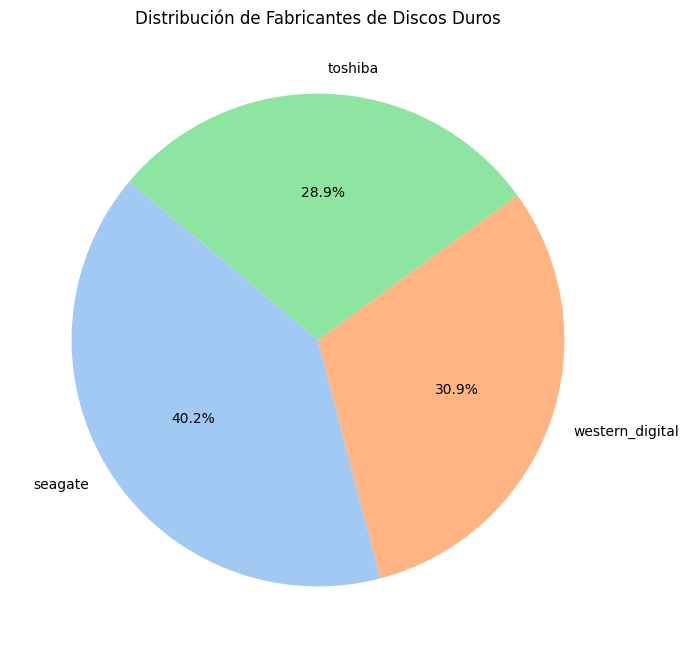

In [58]:
# Cargar el dataset
file_path = "dataset_5.csv"
df = pd.read_csv(file_path)

# Reemplazar "hitachi" por "western_digital" en la columna 'manufacturer'
df['manufacturer'] = df['manufacturer'].replace("hitachi", "western_digital")

# Guardar el dataset actualizado en un nuevo archivo
output_path = "dataset_5_3.csv"
df.to_csv(output_path, index=False)
print(f"Dataset actualizado guardado como '{output_path}'.")

# Contar la frecuencia de cada fabricante en la columna 'manufacturer' después del reemplazo
manufacturer_counts = df['manufacturer'].value_counts()

# Mostrar los resultados en texto
print("Distribución de fabricantes en la columna 'manufacturer':")
for manufacturer, count in manufacturer_counts.items():
    print(f"{manufacturer}: {count} discos")

# Crear un gráfico de pastel para mostrar la distribución de fabricantes actualizada
plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribución de Fabricantes de Discos Duros")
plt.show()

Now we have our final chart, and as we can see, Backblaze operates with three main hard drive manufacturers.

## **Step 6: Converting 'manufacturer' Column to Numeric**

The last step before training the model is to convert the manufacturer column to a numeric value. This is primarily because RandomForest (or any other variant) doesn’t understand letters, as it relies on quantitative relationships between variables.

There are two possible approaches for this:

- **Label Encoding:** Assign a numeric value to each manufacturer. For example, seagate=1, western_digital=2, toshiba=3... This approach is simple and direct, but it may imply an unintended order, as if a higher number equals a better manufacturer.
- **One-Hot Encoding:** This creates three binary columns, one for each manufacturer, with a 0 if it’s not that manufacturer and a 1 if it is. This avoids any implicit ordering and represents manufacturers as independent categories. However, it does add columns, which can increase model training and execution time.

For this project, I will go with One-Hot Encoding. It’s only three additional columns, and it will help the model learn each drive's survival rate based on brand.

Additionally, it allows us to set all three columns to 0 if we want to run the model for a drive from an unknown manufacturer or one not present in the training data. This would make the model rely more on SMART data. We’ll explore this point further in the conclusions and future model versions.

In [59]:
# Cargar el dataset
file_path = "dataset_5_3.csv"
df = pd.read_csv(file_path)

# Inicializar las nuevas columnas con valor 0
df['manufacturer_seagate'] = 0
df['manufacturer_wd'] = 0
df['manufacturer_toshiba'] = 0

# Asignar valor 1 a la columna correspondiente al fabricante en cada fila
df.loc[df['manufacturer'] == 'seagate', 'manufacturer_seagate'] = 1
df.loc[df['manufacturer'] == 'western_digital', 'manufacturer_wd'] = 1
df.loc[df['manufacturer'] == 'toshiba', 'manufacturer_toshiba'] = 1

# Eliminar la columna original 'manufacturer'
df = df.drop(columns=['manufacturer'])

# Verificación del resultado
print("Dataset después de One-Hot Encoding y eliminación de la columna 'manufacturer':")
print(df[['manufacturer_seagate', 'manufacturer_wd', 'manufacturer_toshiba']].head())

# Guardar el nuevo dataset
output_path = "dataset_6.csv"
df.to_csv(output_path, index=False)
print(f"Dataset guardado como '{output_path}' con One-Hot Encoding aplicado a los tres fabricantes y 'manufacturer' eliminada.")

Dataset después de One-Hot Encoding y eliminación de la columna 'manufacturer':
   manufacturer_seagate  manufacturer_wd  manufacturer_toshiba
0                     1                0                     0
1                     0                1                     0
2                     1                0                     0
3                     0                0                     1
4                     1                0                     0
Dataset guardado como 'dataset_6.csv' con One-Hot Encoding aplicado a los tres fabricantes y 'manufacturer' eliminada.


### **Step 6.1:** Final Checks

Let’s verify that our final dataset (`dataset_6.csv`) doesn’t contain any outliers, unexpected values, or any null values that may have been missed. This will be the last step before model training.

In [13]:
# Cargar el dataset
file_path = "dataset_6.csv"
df = pd.read_csv(file_path)

# Verificar si hay valores nulos en todo el dataset
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    print("Error: Hay valores nulos en el dataset:")
    print(null_counts[null_counts > 0])
else:
    print("Verificación pasada: No hay valores nulos en el dataset.")

# Verificar si hay valores fuera de rango en las columnas SMART
smart_columns = [
    'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
    'smart_7_normalized', 'smart_9_normalized', 'smart_10_normalized', 'smart_12_normalized',
    'smart_192_normalized', 'smart_193_normalized', 'smart_197_normalized', 'smart_198_normalized',
    'smart_199_normalized'
]

# Los valores normalizados de SMART suelen estar en el rango [0, 255]
out_of_range_smart = df[smart_columns][(df[smart_columns] < 0) | (df[smart_columns] > 255)].dropna(how='all')
if not out_of_range_smart.empty:
    print("Error: Hay valores fuera del rango [0, 255] en las columnas SMART:")
    print(out_of_range_smart)
else:
    print("Verificación pasada: No hay valores fuera del rango [0, 255] en las columnas SMART.")

# Verificar la columna 'failure' (debe ser binaria: 0 o 1)
invalid_failure_values = df[~df['failure'].isin([0, 1])]
if not invalid_failure_values.empty:
    print("Error: La columna 'failure' contiene valores no binarios (que no son 0 o 1):")
    print(invalid_failure_values[['failure']])
else:
    print("Verificación pasada: La columna 'failure' es binaria (solo contiene 0 y 1).")

# Verificar valores nulos en 'capacity_terabytes'
null_capacity = df['capacity_terabytes'].isnull().sum()
if null_capacity > 0:
    print(f"Error: Hay {null_capacity} valores nulos en 'capacity_terabytes'.")
    print(df[df['capacity_terabytes'].isnull()])
else:
    print("Verificación pasada: No hay valores nulos en 'capacity_terabytes'.")

# Verificar valores fuera del rango razonable (0.5-24 TB) - en 'capacity_terabytes'
out_of_range_capacity = df[(df['capacity_terabytes'] < 0.1) | (df['capacity_terabytes'] > 24)]
if not out_of_range_capacity.empty:
    print("Error: Hay valores inusuales en 'capacity_terabytes' (fuera del rango 0.5-24):")
    print(out_of_range_capacity[['capacity_terabytes']])
else:
    print("Verificación pasada: Todos los valores en 'capacity_terabytes' están en un rango razonable.")

# Verificar que las columnas de fabricantes sean binarias y no tengan valores distintos de 0 y 1
manufacturer_columns = ['manufacturer_seagate', 'manufacturer_wd', 'manufacturer_toshiba']
invalid_manufacturer_values = df[(df[manufacturer_columns] != 0) & (df[manufacturer_columns] != 1)].dropna(how='all')
if not invalid_manufacturer_values.empty:
    print("Error: Las columnas de fabricantes contienen valores no binarios (que no son 0 o 1):")
    print(invalid_manufacturer_values[manufacturer_columns])
else:
    print("Verificación pasada: Las columnas de fabricantes son binarias (solo contienen 0 y 1).")

Verificación pasada: No hay valores nulos en el dataset.
Verificación pasada: No hay valores fuera del rango [0, 255] en las columnas SMART.
Verificación pasada: La columna 'failure' es binaria (solo contiene 0 y 1).
Verificación pasada: No hay valores nulos en 'capacity_terabytes'.
Verificación pasada: Todos los valores en 'capacity_terabytes' están en un rango razonable.
Verificación pasada: Las columnas de fabricantes son binarias (solo contienen 0 y 1).


As we can see, everything is as it should be. We can consider "dataset_6.csv" as our final dataset and begin training.

## **Step 7: Model Training**


Now, with this final dataset cleaned and scaled, I’ll split it into training and test sets (at the CSV level). I’ll train two models: a RandomForestClassifier and an XGBoost.


### **Step 7.1:** Training a RandomForestClassifier

For this first model, I’ll use the **RandomForestClassifier** algorithm.

- **Dataset Split**:
   - I’ll split the dataset at the CSV level with 90% for training and 10% for testing, <u>ensuring class proportions remain consistent</u>. With approximately 283,000 rows, this provides a test set of 28,300 rows, sufficient to reliably evaluate the model's performance.

- **Model Training**:
   To enhance model performance, I used **GridSearchCV** to optimize the following hyperparameters:
   - `n_estimators`: the number of trees in the forest, with values [100, 200, 300] to balance accuracy and efficiency.
   - `max_depth`: the maximum tree depth, set at [10, 20, 30] to limit tree complexity and reduce overfitting.
   - `min_samples_split` and `min_samples_leaf`: the minimum number of samples to split a node and to retain in a leaf, respectively, to improve the model's generalization.
   - `max_features`: the number of features considered at each tree split, with options 'sqrt' and 'log2', aiming for the best split without adding excessive complexity.

   The model was tuned with the goal of maximizing the **F1-Score** for the minority class, facilitating direct comparison with the upcoming XGBoost model. The selected metrics to evaluate final performance are **precision**, **recall**, and **F1-Score**.

In [9]:
# Definir nombres de los archivos de entrenamiento y prueba
train_file = "dataset_6_train.csv"
test_file = "dataset_6_test.csv"

# Verificar si los archivos de entrenamiento y prueba ya existen
if not os.path.exists(train_file) or not os.path.exists(test_file):
    # Cargar el dataset original
    data = pd.read_csv("dataset_6.csv")

    # Dividir el dataset en entrenamiento (90%) y prueba (10%) manteniendo la proporción de clases
    # Solo en caso de no existir estos CSV, claro.
    train_data, test_data = train_test_split(
        data,
        test_size=0.1,
        stratify=data['failure']
    )

    # Guardar los conjuntos de entrenamiento y prueba como archivos CSV
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print(f"Conjuntos de entrenamiento y prueba guardados como '{train_file}' y '{test_file}' respectivamente.")
else:
    print(f"Los archivos '{train_file}' y '{test_file}' ya existen. Se utilizarán para el entrenamiento y prueba.")

# Cargar los conjuntos de entrenamiento y prueba
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Separar características y variable objetivo en el conjunto de entrenamiento
X_train = train_data.drop(columns=['failure'])
y_train = train_data['failure']

# Separar características y variable objetivo en el conjunto de prueba
X_test = test_data.drop(columns=['failure'])
y_test = test_data['failure']

# Configurar el modelo con RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Definir el grid de hiperparámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],           # Número de árboles
    'max_depth': [10, 20, 30],                 # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],           # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],             # Mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2']           # Número de características a considerar al buscar la mejor división
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',  # También podría colocarse 'average_precision'
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Calcular métricas
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

print("Precisión:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Guardar el modelo entrenado
joblib.dump(best_rf, 'modelo_randomforest.pkl')
print("Modelo guardado como 'modelo_randomforest.pkl'.")

Los archivos 'dataset_6_train.csv' y 'dataset_6_test.csv' ya existen. Se utilizarán para el entrenamiento y prueba.
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  22.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=30

/root/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  42.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  42.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  43.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  22.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=s

/root/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores hiperparámetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Precisión: 0.88
Recall: 0.7
F1-Score: 0.78
Modelo guardado como 'modelo_randomforest.pkl'.


### **Step 7.2:** Training an XGBoost Model

In addition to the Random Forest model, I trained a second model using the **XGBoost** algorithm. XGBoost is well-regarded for its performance in classification tasks with complex data and its ability to handle imbalanced datasets through **gradient boosting**, which will be quite beneficial for our use case.

- **Dataset Split**:
   - As with the previous model, 90% of the dataset was used for training and 10% for testing, maintaining the same split to enable an accurate comparison between the two models.

- **Model Training**:
   For the XGBoost model, I configured a grid of hyperparameters for GridSearchCV, including:
   - `n_estimators`: the number of trees in the model, with values [100, 200, 300] to balance accuracy and model complexity.
   - `max_depth`: the maximum depth of each tree, selecting values [3, 6, 10] to optimize learning and prevent overfitting.
   - `learning_rate`: the learning rate, with values [0.01, 0.1, 0.2], to adjust the model’s convergence speed.
   - `subsample` and `colsample_bytree`: sampling ratios for rows and columns, respectively, which enhance model robustness against noise and reduce overfitting risk.

   Using **GridSearchCV** and optimizing for the `f1` score, the model was tuned to maximize the F1-Score for the minority class, allowing for direct comparison with the Random Forest model.


In [8]:
# Definir nombres de archivos para los conjuntos de entrenamiento y prueba
TRAIN_CSV = "dataset_6_train.csv"
TEST_CSV = "dataset_6_test.csv"

# Verificar si los archivos de entrenamiento y prueba ya existen
if not os.path.exists(TRAIN_CSV) or not os.path.exists(TEST_CSV):
    # Cargar el dataset completo
    data = pd.read_csv("dataset_6.csv")

    # Separar características y la variable objetivo
    X = data.drop(columns=['failure'])
    y = data['failure']

    # Dividir en conjuntos de entrenamiento (90%) y prueba (10%) manteniendo la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.1,
        stratify=y # Mantener proporción de clases en train y test
    )

    # Combinar características y variable objetivo para guardar en CSV
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    # Guardar los conjuntos de entrenamiento y prueba en archivos CSV
    train.to_csv(TRAIN_CSV, index=False)
    test.to_csv(TEST_CSV, index=False)
    print(f"Dataset dividido y guardado como '{TRAIN_CSV}' y '{TEST_CSV}'.")
else:
    print(f"Archivos '{TRAIN_CSV}' y '{TEST_CSV}' ya existen. Cargando los datos.")

# Cargar los conjuntos de entrenamiento y prueba desde los archivos CSV
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

# Separar características y la variable objetivo para entrenamiento
X_train = train.drop(columns=['failure'])
y_train = train['failure']

# Separar características y la variable objetivo para prueba
X_test = test.drop(columns=['failure'])
y_test = test['failure']

# Configurar el modelo con XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss')  # Usar logloss como métrica - mide incertidumbre de clase

# Definir el grid de hiperparámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_xgb.predict(X_test)

# Calcula y redondea cada métrica a 2 decimales
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Imprime cada métrica
print("Precisión:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Guardar el modelo entrenado
joblib.dump(best_xgb, 'modelo_xgboost.pkl')
print("Modelo guardado como 'modelo_xgboost.pkl'.")

Archivos 'dataset_6_train.csv' y 'dataset_6_test.csv' ya existen. Cargando los datos.
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   5.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.7, learning

### **Step 7.3:** Choosing Between Both Models

The metrics for the RandomForest model were:

---

**Precision:** 0.88

**Recall:** 0.7

**F1-Score:** 0.78

**<u>While the XGBoost results were:</u>**

**Precision:** 0.88

**Recall:** 0.7

**F1-Score:** 0.78

---

From these results, I can draw the following conclusions:

1. **Similarity**: Both models yield identical results.

2. **Model Choice**: Given these results, <u>it's difficult to favor one model over the other</u>, as they appear to be identical. Let’s continue analyzing them in further detail.

## **Step 8: Model Evaluation - Graphs, Thresholds & Conclusions**


In this step, we’ll examine graphs for both models to gather more insights and determine which one performs better.

Additionally, at the end, we’ll address threshold adjustment, which is essential in a project of this nature.

### **Step 8.1:** Confusion Matrix - Both Models

To gain a deeper understanding of each model’s performance on each class, I generated the **confusion matrix**. This matrix displays the number of drives correctly classified as failing and non-failing, as well as cases of false alarms and undetected failures.

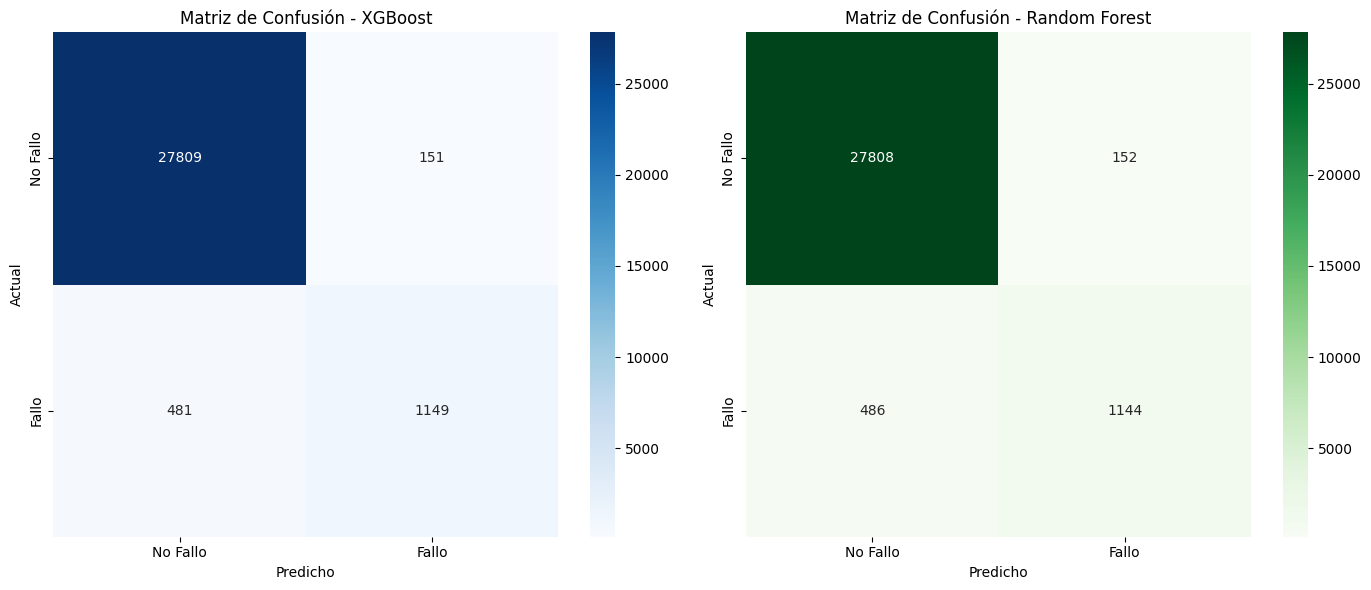

In [4]:
# Cargar los datasets de entrenamiento y prueba
train_data = pd.read_csv("dataset_6_train.csv")
test_data = pd.read_csv("dataset_6_test.csv")

# Separar características y la variable objetivo en el conjunto de entrenamiento
X_train = train_data.drop(columns=['failure'])
y_train = train_data['failure']

# Separar características y la variable objetivo en el conjunto de prueba
X_test = test_data.drop(columns=['failure'])
y_test = test_data['failure']

# Cargar el primer modelo (XGBoost)
modelo_xgboost = joblib.load('modelo_xgboost.pkl')

# Realizar predicciones con el primer modelo
y_pred_xgboost = modelo_xgboost.predict(X_test)

# Cargar el segundo modelo (Random Forest)
modelo_randomforest = joblib.load('modelo_randomforest.pkl')

# Realizar predicciones con el segundo modelo
y_pred_randomforest = modelo_randomforest.predict(X_test)

# Generar las matrices de confusión
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
cm_randomforest = confusion_matrix(y_test, y_pred_randomforest)

# Configurar la figura para dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de Confusión para XGBoost
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fallo', 'Fallo'],
            yticklabels=['No Fallo', 'Fallo'],
            ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicho')
axes[0].set_title('Matriz de Confusión - XGBoost')

# Matriz de Confusión para Random Forest
sns.heatmap(cm_randomforest, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Fallo', 'Fallo'],
            yticklabels=['No Fallo', 'Fallo'],
            ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicho')
axes[1].set_title('Matriz de Confusión - Random Forest')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar las matrices de confusión
plt.show()

As we can see, both are quite similar.

### **Step 8.2:** Detailed Classification Report - Both Models

For a comprehensive evaluation of the predictions, a **detailed classification report** has been generated, including precision, recall, and F1-Score for both classes (failing drives and operational drives).

In [11]:
# Cargar los datasets de entrenamiento y prueba
train_data = pd.read_csv("dataset_6_train.csv")
test_data = pd.read_csv("dataset_6_test.csv")

# Separar características y la variable objetivo en el conjunto de entrenamiento
X_train = train_data.drop(columns=['failure'])
y_train = train_data['failure']

# Separar características y la variable objetivo en el conjunto de prueba
X_test = test_data.drop(columns=['failure'])
y_test = test_data['failure']

# Función para cargar el modelo y mostrar el reporte de clasificación
def mostrar_reporte(model_path, modelo_nombre):
    # Cargar el modelo entrenado
    modelo = joblib.load(model_path)

    # Realizar predicciones
    y_pred = modelo.predict(X_test)

    # Generar y mostrar el reporte de clasificación
    report = classification_report(y_test, y_pred, target_names=['No Fallo', 'Fallo'])
    print(f"\nReporte de Clasificación para {modelo_nombre}:\n", report)

# Mostrar reporte para el modelo XGBoost
mostrar_reporte('modelo_xgboost.pkl', 'XGBoost')

# Mostrar reporte para el modelo RandomForest
mostrar_reporte('modelo_randomforest.pkl', 'RandomForest')


Reporte de Clasificación para XGBoost:
               precision    recall  f1-score   support

    No Fallo       0.98      0.99      0.99     27960
       Fallo       0.88      0.70      0.78      1630

    accuracy                           0.98     29590
   macro avg       0.93      0.85      0.89     29590
weighted avg       0.98      0.98      0.98     29590


Reporte de Clasificación para RandomForest:
               precision    recall  f1-score   support

    No Fallo       0.98      0.99      0.99     27960
       Fallo       0.88      0.70      0.78      1630

    accuracy                           0.98     29590
   macro avg       0.93      0.85      0.89     29590
weighted avg       0.98      0.98      0.98     29590



As we can see, both models produce quite similar values.

### **Step 8.3:** Feature Importance - Both Models

In this analysis, I examined the **importance of each feature for both models**. The goal is to identify which characteristics are most influential in predicting drive failures and to see what insights we can gather from them.

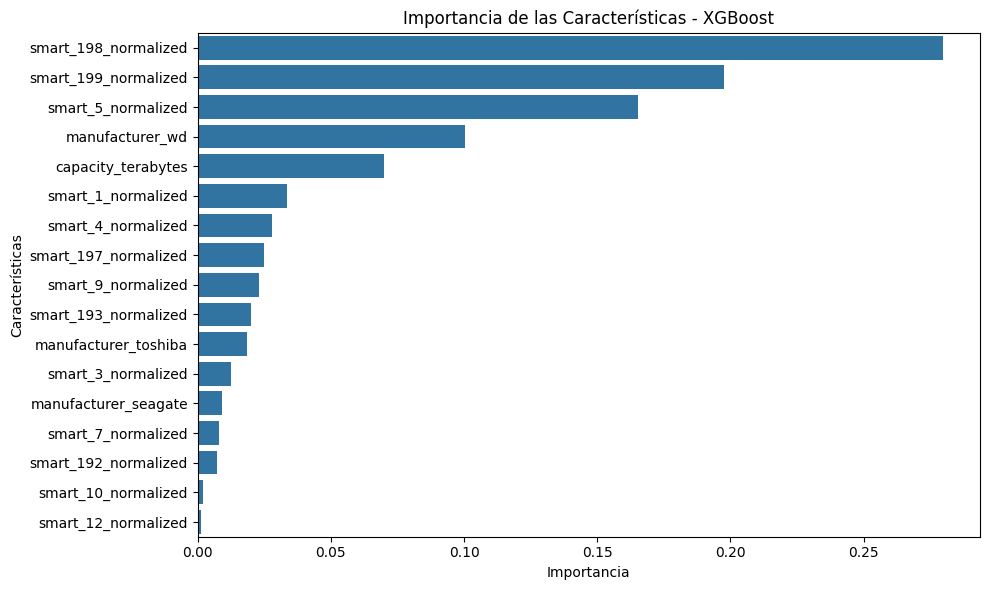

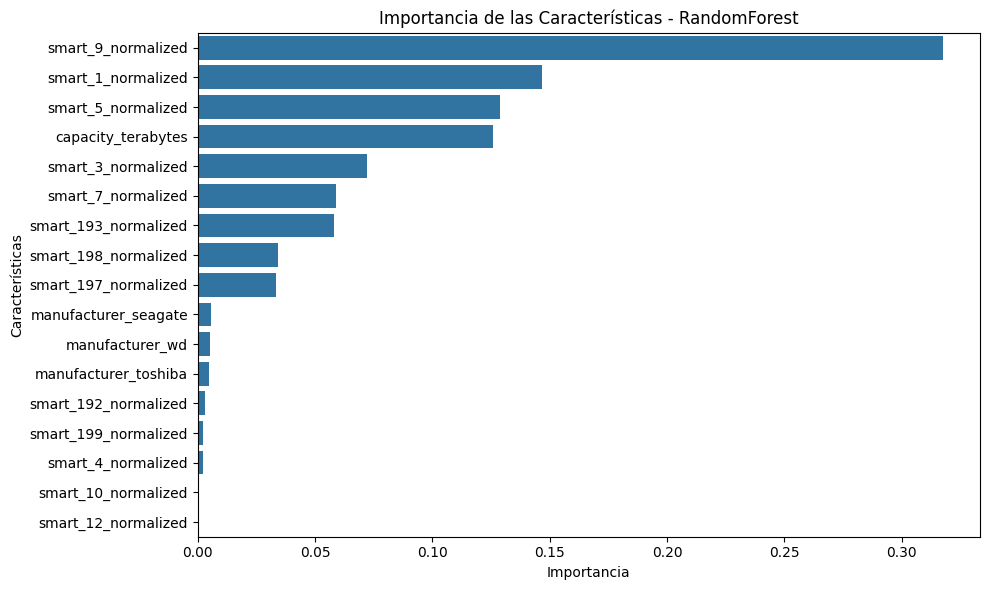

In [5]:
# Cargar el modelo XGBoost
best_xgb = joblib.load('modelo_xgboost.pkl')

# Obtener la importancia de las características para XGBoost
feature_importances_xgb = best_xgb.feature_importances_
features_xgb = best_xgb.feature_names_in_

# Crear un DataFrame para XGBoost
importance_df_xgb = pd.DataFrame({
    'Feature': features_xgb,
    'Importance': feature_importances_xgb
})

# Ordenar por importancia
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Cargar el modelo RandomForest
best_rf = joblib.load('modelo_randomforest.pkl')

# Obtener la importancia de las características para RandomForest
feature_importances_rf = best_rf.feature_importances_
features_rf = best_rf.feature_names_in_

# Crear un DataFrame para RandomForest
importance_df_rf = pd.DataFrame({
    'Feature': features_rf,
    'Importance': feature_importances_rf
})

# Ordenar por importancia
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características para XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb)
plt.title('Importancia de las Características - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# Graficar la importancia de las características para RandomForest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Importancia de las Características - RandomForest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

The results are quite interesting. Although both models performed similarly, they differ significantly in the importance assigned to each feature. Let's review each model in detail:

- **Random Forest**: Focuses on SMART attribute 9 (Power-on hours), highlighting the total operational age of the HDD as a critical factor.

- **XGBoost**: Prioritizes SMART attributes 198 (Offline uncorrectable sector count), 199 (UltraDMA CRC error count), and 5 (Reallocated sector count), indicating a focus on physical indicators of failure.

This suggests that while both models achieve nearly identical performance, Random Forest places greater emphasis on the age of the HDD, whereas XGBoost is more attuned to physical failure indicators.



### **Step 8.4:** Adjustment of Prediction Threshold

Currently, without any modifications, the threshold is set at 50%. This means that if the model is 40% confident a hard drive will fail, it will label it as "no issues," as it is <50%. Similarly, values above 50% will be marked as "failed."

The idea now is to run a script that tests all possible thresholds, from 10% to 90%, to identify the threshold that maximizes the F1-Score. If multiple thresholds yield the same F1-Score, the one with the highest recall will be selected.

This way, we fine-tune the model, aiming to find the *sweet spot* between precision and recall, potentially at the cost of increasing false positives.


In [14]:
# Función para optimizar el umbral y generar el reporte de clasificación
def optimizar_umbral(modelo_path, modelo_nombre, X, y_true):
    print(f"\n{'='*60}")
    print(f"Evaluando el modelo: {modelo_nombre}")
    print(f"{'='*60}\n")

    # Cargar el modelo entrenado
    try:
        model = joblib.load(modelo_path)
    except FileNotFoundError:
        print(f"Error: El archivo '{modelo_path}' no se encontró.")
        return
    except Exception as e:
        print(f"Error al cargar el modelo '{modelo_nombre}': {e}")
        return

    # Obtener las probabilidades predichas para la clase 1
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_decision = model.decision_function(X)
        y_probs = 1 / (1 + np.exp(-y_decision))
    else:
        print(f"Error: El modelo '{modelo_nombre}' no tiene métodos 'predict_proba' o 'decision_function'.")
        return

    # Definir un rango de umbrales a probar
    thresholds = np.arange(0.1, 0.901, 0.005)

    # Almacenar los resultados
    resultados = []

    for umbral in thresholds:
        y_pred = (y_probs >= umbral).astype(int)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        precision = report['1']['precision']
        support = report['1']['support']
        accuracy = report['accuracy']

        resultados.append({
            'umbral': umbral,
            'recall_clase_1': recall,
            'f1_score_clase_1': f1,
            'precision_clase_1': precision,
            'soporte_clase_1': support,
            'exactitud': accuracy
        })

    # Convertir los resultados a un DataFrame
    df_resultados = pd.DataFrame(resultados)

    # Encontrar el valor máximo de F1-score para la clase 1
    max_f1 = df_resultados['f1_score_clase_1'].max()

    # Filtrar los umbrales que alcanzan el máximo F1-score
    candidatos = df_resultados[df_resultados['f1_score_clase_1'] == max_f1]

    # Si hay múltiples candidatos, seleccionar el que tiene el mejor recall
    mejor_idx = candidatos['recall_clase_1'].idxmax()
    mejor_umbral = df_resultados.loc[mejor_idx, 'umbral']
    mejor_recall = df_resultados.loc[mejor_idx, 'recall_clase_1']
    mejor_f1 = df_resultados.loc[mejor_idx, 'f1_score_clase_1']
    mejor_precision = df_resultados.loc[mejor_idx, 'precision_clase_1']
    mejor_soporte = df_resultados.loc[mejor_idx, 'soporte_clase_1']
    mejor_exactitud = df_resultados.loc[mejor_idx, 'exactitud']

    # Aplicar el mejor umbral para obtener las predicciones finales
    y_pred_mejor = (y_probs >= mejor_umbral).astype(int)

    # Generar el reporte de clasificación con el mejor umbral
    reporte_final = classification_report(y_true, y_pred_mejor, zero_division=0)

    # Imprimir los resultados
    print(f"Umbral óptimo para {modelo_nombre}: {mejor_umbral:.3f}")
    print(f"Recall para la clase 1: {mejor_recall:.4f}")
    print(f"F1-score para la clase 1: {mejor_f1:.4f}")
    print(f"Precision para la clase 1: {mejor_precision:.4f}")
    print(f"Soporte para la clase 1: {int(mejor_soporte)}")
    print(f"Exactitud del modelo: {mejor_exactitud:.4f}\n")
    print("Reporte de clasificación actualizado:\n")
    print(reporte_final)
    print(f"{'='*60}\n")

def main():
    # Cargar el dataset
    try:
        data = pd.read_csv('dataset_6_test.csv')
    except FileNotFoundError:
        print("Error: El archivo 'dataset_6_test.csv' no se encontró.")
        return
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        return

    # Definir la columna objetivo
    columna_objetivo = 'failure'

    if columna_objetivo not in data.columns:
        raise ValueError(f"La columna objetivo '{columna_objetivo}' no se encuentra en el dataset.")

    # Separar las características y la variable objetivo
    X = data.drop(columns=[columna_objetivo])
    y_true = data[columna_objetivo]

    # Lista de modelos a evaluar
    modelos = [
        {'path': 'modelo_xgboost.pkl', 'nombre': 'XGBoost'},
        {'path': 'modelo_randomforest.pkl', 'nombre': 'Random Forest'}
    ]

    # Evaluar cada modelo
    for modelo in modelos:
        optimizar_umbral(modelo['path'], modelo['nombre'], X, y_true)

if __name__ == "__main__":
    main()


Evaluando el modelo: XGBoost

Umbral óptimo para XGBoost: 0.405
Recall para la clase 1: 0.7479
F1-score para la clase 1: 0.7936
Precision para la clase 1: 0.8454
Soporte para la clase 1: 1630
Exactitud del modelo: 0.9786

Reporte de clasificación actualizado:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27960
           1       0.85      0.75      0.79      1630

    accuracy                           0.98     29590
   macro avg       0.92      0.87      0.89     29590
weighted avg       0.98      0.98      0.98     29590



Evaluando el modelo: Random Forest

Umbral óptimo para Random Forest: 0.385
Recall para la clase 1: 0.7577
F1-score para la clase 1: 0.7922
Precision para la clase 1: 0.8300
Soporte para la clase 1: 1630
Exactitud del modelo: 0.9781

Reporte de clasificación actualizado:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27960
           1       0.83    

With this approach, we started to see improvements, achieving a 0.01 increase in the F1-Score for both models.

- **Random Forest**: Displayed a slightly higher recall, making it marginally better at identifying failures.
- **XGBoost**: Showed a slightly higher precision, indicating it was marginally more accurate in its positive predictions.

Thus, each model demonstrated a very slight advantage in either recall (Random Forest) or precision (XGBoost), reflecting their respective strengths.

## **Step 9: Model Stacking**

We’ve just seen how adjusting the threshold can improve recall and, subsequently, the F1-Score, though at the cost of increasing false positives. However, considering that each of these models (RandomForest and XGBoost) has assigned different importances to each attribute, could we not attempt to combine their outputs to obtain an improved model? Especially given that one model seems to prioritize total hours of operation, while the other focuses more on physical failures.

Therefore, we’ll proceed to run a script that tests various combinations of weights and thresholds. The idea is as follows:

- Test combinations of weights between the XGBoost and RandomForest models (for example, 0.3 and 0.7) and, for each combination, test all possible thresholds (from 0.10 to 0.9, in increments of 0.01).
- The weights to be tested for each model will range from 0.00 to 1.00, with increments of 0.01.
- Additionally, with the information gathered, we’ll determine the best combinations for:
  - Maximizing the F1-Score
  - Maximizing Precision
  - Maximizing Recall
- Finally, in cases where the maximum values of these three metrics are tied, the combination with the highest recall/F1-Score will be selected as the best.

It’s worth noting that this entire process will be executed with the test CSV, as it wouldn’t make sense to include rows seen during training.

In [15]:
def main():
    # Cargar el conjunto de datos de prueba
    test_df = pd.read_csv("dataset_6_test.csv")

    # Definir columna objetivo (failure)
    if 'failure' not in test_df.columns:
        raise ValueError("El conjunto de datos de debe contener la columna 'failure'.")

    X_test = test_df.drop('failure', axis=1)
    y_test = test_df['failure']

    # Cargar los modelos entrenados
    model_xgb = joblib.load('modelo_xgboost.pkl')
    model_rf = joblib.load('modelo_randomforest.pkl')

    # Obtener las probabilidades de predicción para la clase positiva (1)
    pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
    pred_rf = model_rf.predict_proba(X_test)[:, 1]

    # Inicializar las variables para las mejores combinaciones
    best_f1 = -1
    best_weight_x_f1 = 0
    best_weight_rf_f1 = 0
    best_threshold_f1 = 0.5
    best_f1_recall = -1  # Métrica secundaria para F1

    best_precision = -1
    best_weight_x_precision = 0
    best_weight_rf_precision = 0
    best_threshold_precision = 0.5
    best_precision_f1 = -1  # Métrica secundaria para Precisión

    best_recall = -1
    best_weight_x_recall = 0
    best_weight_rf_recall = 0
    best_threshold_recall = 0.5
    best_recall_f1 = -1  # Métrica secundaria para Recall

    # Iterar sobre los pesos de 0 a 100 (equivalente a 0.00 a 1.00 en pasos de 0.01)
    for weight_x in range(0, 101):
        weight_x_normalized = weight_x / 100
        weight_rf_normalized = 1 - weight_x_normalized

        # Combinar las predicciones ponderadas
        combined_pred = weight_x_normalized * pred_xgb + weight_rf_normalized * pred_rf

        # Iterar sobre los umbrales de 0.10 a 0.90 con incrementos de 0.01
        for threshold_int in range(10, 91):  # 10 a 90 inclusive
            threshold = threshold_int / 100

            # Generar etiquetas binarias basadas en el umbral
            predicted_labels = (combined_pred >= threshold).astype(int)

            # Calcular las métricas
            f1 = f1_score(y_test, predicted_labels)
            precision = precision_score(y_test, predicted_labels, zero_division=0)
            recall = recall_score(y_test, predicted_labels, zero_division=0)

            # Actualizar la mejor combinación para F1 Score
            if f1 > best_f1:
                best_f1 = f1
                best_weight_x_f1 = weight_x_normalized
                best_weight_rf_f1 = weight_rf_normalized
                best_threshold_f1 = threshold
                best_f1_recall = recall
            elif f1 == best_f1 and recall > best_f1_recall:
                best_weight_x_f1 = weight_x_normalized
                best_weight_rf_f1 = weight_rf_normalized
                best_threshold_f1 = threshold
                best_f1_recall = recall

            # Actualizar la mejor combinación para Precisión
            if precision > best_precision:
                best_precision = precision
                best_weight_x_precision = weight_x_normalized
                best_weight_rf_precision = weight_rf_normalized
                best_threshold_precision = threshold
                best_precision_f1 = f1
            elif precision == best_precision and f1 > best_precision_f1:
                best_weight_x_precision = weight_x_normalized
                best_weight_rf_precision = weight_rf_normalized
                best_threshold_precision = threshold
                best_precision_f1 = f1

            # Actualizar la mejor combinación para Recall
            if recall > best_recall:
                best_recall = recall
                best_weight_x_recall = weight_x_normalized
                best_weight_rf_recall = weight_rf_normalized
                best_threshold_recall = threshold
                best_recall_f1 = f1
            elif recall == best_recall and f1 > best_recall_f1:
                best_weight_x_recall = weight_x_normalized
                best_weight_rf_recall = weight_rf_normalized
                best_threshold_recall = threshold
                best_recall_f1 = f1

    # Generar las predicciones finales para cada mejor combinación
    # Para F1 Score
    final_pred_f1 = best_weight_x_f1 * pred_xgb + best_weight_rf_f1 * pred_rf
    final_labels_f1 = (final_pred_f1 >= best_threshold_f1).astype(int)

    # Para Precisión
    final_pred_precision = best_weight_x_precision * pred_xgb + best_weight_rf_precision * pred_rf
    final_labels_precision = (final_pred_precision >= best_threshold_precision).astype(int)

    # Para Recall
    final_pred_recall = best_weight_x_recall * pred_xgb + best_weight_rf_recall * pred_rf
    final_labels_recall = (final_pred_recall >= best_threshold_recall).astype(int)

    # Imprimir los resultados
    print("===== Mejor Combinación para Maximizar F1 Score =====")
    print(f"Peso XGBoost: {best_weight_x_f1:.2f}, Peso RandomForest: {best_weight_rf_f1:.2f}, Umbral: {best_threshold_f1:.2f}")
    print(f"Mejor F1 Score: {best_f1:.4f}")
    print("\nReporte de Clasificación para F1 Score:")
    print(classification_report(y_test, final_labels_f1))

    print("\n===== Mejor Combinación para Maximizar Precisión =====")
    print(f"Peso XGBoost: {best_weight_x_precision:.2f}, Peso RandomForest: {best_weight_rf_precision:.2f}, Umbral: {best_threshold_precision:.2f}")
    print(f"Mejor Precisión: {best_precision:.4f}")
    print("\nReporte de Clasificación para Precisión:")
    print(classification_report(y_test, final_labels_precision))

    print("\n===== Mejor Combinación para Maximizar Recall =====")
    print(f"Peso XGBoost: {best_weight_x_recall:.2f}, Peso RandomForest: {best_weight_rf_recall:.2f}, Umbral: {best_threshold_recall:.2f}")
    print(f"Mejor Recall: {best_recall:.4f}")
    print("\nReporte de Clasificación para Recall:")
    print(classification_report(y_test, final_labels_recall))

if __name__ == "__main__":
    main()

===== Mejor Combinación para Maximizar F1 Score =====
Peso XGBoost: 0.47, Peso RandomForest: 0.53, Umbral: 0.37
Mejor F1 Score: 0.7964

Reporte de Clasificación para F1 Score:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27960
           1       0.83      0.76      0.80      1630

    accuracy                           0.98     29590
   macro avg       0.91      0.88      0.89     29590
weighted avg       0.98      0.98      0.98     29590


===== Mejor Combinación para Maximizar Precisión =====
Peso XGBoost: 0.34, Peso RandomForest: 0.66, Umbral: 0.90
Mejor Precisión: 0.9899

Reporte de Clasificación para Precisión:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27960
           1       0.99      0.48      0.65      1630

    accuracy                           0.97     29590
   macro avg       0.98      0.74      0.82     29590
weighted avg       0.97      0.97      0.97  

As we can see, these combinations provide some <u>**very useful insights:**</u>

- Using the values "XGBoost Weight: 0.47, RandomForest Weight: 0.53, Threshold: 0.37" to <u>maximize the F1-Score</u>, the model achieves a 83% accuracy in predicting if a hard drive will fail. However, it only detects 76% of all defective drives.
- Using the values "XGBoost Weight: 0.34, RandomForest Weight: 0.66, Threshold: 0.9" to <u>maximize precision</u>, the model achieves a **99% precision** in predicting if a hard drive will fail. The downside is that it only identifies 48% of the total drives in the test set. However, this combination is useful because, if it predicts "The drive will fail," we can treat this as an indication of an **imminent failure.**
- Using the values "XGBoost Weight: 0.23, RandomForest Weight: 0.77, Threshold: 0.10" to <u>maximize recall</u>, the model achieves 60% accuracy in predicting hard drive failure and detects 86% of the drives that are likely to fail, showing an increase in recall.

With this results, I believe an approach combining these three configurations could be very effective.

For example, if you want to know if a hard drive is going to fail and:
- The F1-oriented model predicts **no failure.**
- The precision-oriented model predicts **failure.**
- The recall-oriented model predicts **no failure.**

Knowing that the precision-oriented model **rarely makes errors**, this would signal a critical alert. Another example:

- The F1-oriented model predicts **no failure.**
- The precision-oriented model predicts **no failure.**
- The recall-oriented model predicts **failure.**

Since the precision-oriented model predicts no failure, it’s unlikely to be a critical issue. Additionally, since the F1-oriented model also predicts no failure, and has high precision, this doesn’t qualify as a "severe" alert. The recall-oriented model indicates a failure, but due to its lower precision, we interpret this as a "minor alert, monitor it."

Following an approach based on these three combinations, and implementing a sequence of elifs, I believe we can achieve a robust "final_model." This is exactly what we will proceed with in the next step.

## **Step 10: Implementation and Hypothetical Production Use**


In this step, we’ll implement the approach explained earlier: running the top 3 combinations of weights and thresholds across both models (RandomForest and XGBoost) and, based on their predictions, displaying different error messages.

To demonstrate this effectively, the following code cell will select 3 random drives from our test set, ensuring that at least one of them has `failure=1`, and it will print an assessment based on this if-else decision tree. Then, it will indicate whether the drive is indeed expected to fail or if it is healthy.

The goal is to simulate the model’s performance once “deployed.” Given that the minority class (failing drives) is so low, we force the selection to display at least one drive that will fail.

Feel free to run this cell multiple times to observe how it responds to different drives.

In [17]:
def cargar_modelos(ruta_xgb, ruta_rf):
    """
    Carga los modelos XGBoost y RandomForest desde archivos .pkl
    """
    if not os.path.exists(ruta_xgb):
        print(f"🚫 Error: El archivo '{ruta_xgb}' no fue encontrado.")
        sys.exit(1)
    if not os.path.exists(ruta_rf):
        print(f"🚫 Error: El archivo '{ruta_rf}' no fue encontrado.")
        sys.exit(1)

    try:
        modelo_xgboost = joblib.load(ruta_xgb)
        modelo_randomforest = joblib.load(ruta_rf)
    except Exception as e:
        print(f"🚫 Error al cargar los modelos: {e}")
        sys.exit(1)

    return modelo_xgboost, modelo_randomforest

def cargar_dataset(ruta_csv):
    """
    Carga el dataset desde un archivo CSV
    """
    if not os.path.exists(ruta_csv):
        print(f"🚫 Error: El archivo '{ruta_csv}' no fue encontrado.")
        sys.exit(1)

    try:
        df = pd.read_csv(ruta_csv)
    except Exception as e:
        print(f"🚫 Error al leer el CSV: {e}")
        sys.exit(1)

    return df

def seleccionar_filas_aleatorias(df):
    """
    Selecciona una fila aleatoria donde 'failure' sea 1 y dos filas aleatorias sin restricciones
    """
    fila_failure = df[df['failure'] == 1].sample(n=1)  # Selecciona una fila donde failure sea 1
    filas_aleatorias = df.sample(n=2)  # Selecciona dos filas aleatorias sin restricciones
    return pd.concat([fila_failure, filas_aleatorias])  # Combina ambas selecciones

def obtener_probabilidades(fila, modelo_xgb, modelo_rf, columnas_features):
    """
    Obtiene las probabilidades de predicción de ambos modelos para una fila dada
    """
    caracteristicas = fila[columnas_features].to_frame().T

    try:
        proba_xgb = modelo_xgb.predict_proba(caracteristicas)[0][1]  # Probabilidad de clase 1
        proba_rf = modelo_rf.predict_proba(caracteristicas)[0][1]
    except Exception as e:
        print(f"🚫 Error al realizar predicciones: {e}")
        sys.exit(1)

    print(f"🔍 Probabilidades para ID {fila.name}: XGBoost={proba_xgb:.4f}, RandomForest={proba_rf:.4f}")  # Depuración

    return proba_xgb, proba_rf

def aplicar_combinacion(proba_xgb, proba_rf, peso_xgb, peso_rf, umbral):
    """
    Combina las probabilidades usando pesos y umbral
    """
    # Calcular la suma ponderada
    suma_ponderada = (peso_xgb * proba_xgb) + (peso_rf * proba_rf)

    # Aplicar el umbral para obtener la predicción final
    pred_combinada = 1 if suma_ponderada >= umbral else 0

    return pred_combinada

def generar_mensaje(pred_f1, pred_precision, pred_recall):
    """
    Genera un mensaje específico basado en las predicciones combinadas
    """
    preds = (pred_f1, pred_precision, pred_recall)

    if preds == (0, 0, 0):
        return "✅ No se detectaron fallos visibles. Parece estar en buen estado."
    elif preds == (0, 0, 1):
        return "⚠️ Indicios iniciales de fallo. Monitoreo recomendado."
    elif preds == (0, 1, 0):
        return "❗ Alta probabilidad de fallo crítico. Considera reemplazo inmediato."
    elif preds == (0, 1, 1):
        return "❗ Fallo crítico detectado. Reemplazo necesario."
    elif preds == (1, 0, 0):
        return "⚠️ Posible fallo detectado. Revisar diagnósticos y estado del disco."
    elif preds == (1, 0, 1):
        return "⚠️ Alta probabilidad de fallo. Considerar reemplazo y monitoreo."
    elif preds == (1, 1, 0):
        return "❗ Fallo inminente confirmado. Reemplazo urgente."
    elif preds == (1, 1, 1):
        return "❗ EMERGENCIA: Fallo seguro. Reemplazo inmediato indispensable."
    else:
        return "❓ Estado de predicción desconocido. Revisar modelos y datos."

def main():
    # Rutas de los modelos y dataset
    ruta_modelo_xgb = "modelo_xgboost.pkl"
    ruta_modelo_rf = "modelo_randomforest.pkl"
    ruta_dataset = "dataset_6_test.csv"

    # Cargar modelos
    modelo_xgboost, modelo_randomforest = cargar_modelos(ruta_modelo_xgb, ruta_modelo_rf)

    # Cargar dataset
    df = cargar_dataset(ruta_dataset)

    # Verificar que la columna 'failure' existe
    if 'failure' not in df.columns:
        print("🚫 Error: La columna 'failure' no está presente en el dataset.")
        sys.exit(1)

    # Definir las características (excluir 'failure')
    columnas_features = [
        'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized',
        'smart_5_normalized', 'smart_7_normalized', 'smart_9_normalized',
        'smart_10_normalized', 'smart_12_normalized', 'smart_192_normalized',
        'smart_193_normalized', 'smart_197_normalized', 'smart_198_normalized',
        'smart_199_normalized', 'capacity_terabytes', 'manufacturer_seagate',
        'manufacturer_wd', 'manufacturer_toshiba'
    ]

    # Verificar que todas las columnas necesarias están presentes
    for col in columnas_features:
        if col not in df.columns:
            print(f"🚫 Error: La columna '{col}' no está presente en el dataset.")
            sys.exit(1)

    # Seleccionar filas aleatorias según los criterios especificados
    filas_aleatorias = seleccionar_filas_aleatorias(df)

    # Definir las combinaciones óptimas
    # REEMPLAZA ESTOS VALORES SI OBTUVISTE UNOS MEJORES
    # TRAS UN "RUN ALL" DE ESTE COLLAB
    combinaciones = {
        "Max F1": {
            "peso_xgb": 0.84,
            "peso_rf": 0.16,
            "umbral": 0.42
        },
        "Max Precisión": {
            "peso_xgb": 0.7,
            "peso_rf": 0.3,
            "umbral": 0.90
        },
        "Max Recall": {
            "peso_xgb": 0.20,
            "peso_rf": 0.80,
            "umbral": 0.10
        }
    }

    # Procesar cada fila seleccionada
    for indice, fila in filas_aleatorias.iterrows():
        # Obtener probabilidades de predicción de ambos modelos
        proba_xgb, proba_rf = obtener_probabilidades(fila, modelo_xgboost, modelo_randomforest, columnas_features)

        # Aplicar combinaciones
        pred_f1 = aplicar_combinacion(proba_xgb, proba_rf,
                                      combinaciones["Max F1"]["peso_xgb"],
                                      combinaciones["Max F1"]["peso_rf"],
                                      combinaciones["Max F1"]["umbral"])

        pred_precision = aplicar_combinacion(proba_xgb, proba_rf,
                                             combinaciones["Max Precisión"]["peso_xgb"],
                                             combinaciones["Max Precisión"]["peso_rf"],
                                             combinaciones["Max Precisión"]["umbral"])

        pred_recall = aplicar_combinacion(proba_xgb, proba_rf,
                                          combinaciones["Max Recall"]["peso_xgb"],
                                          combinaciones["Max Recall"]["peso_rf"],
                                          combinaciones["Max Recall"]["umbral"])

        # Generar mensaje basado en las predicciones combinadas
        mensaje = generar_mensaje(pred_f1, pred_precision, pred_recall)

        # Determinar el estado real del disco basado en la columna 'failure'
        estado_real = "💀 Muerto" if fila['failure'] == 1 else "✅ Sano"

        print("="*60)
        print(f"🔍 Registro ID: {indice}")
        print(f"📊 Predicciones:")
        print(f"  - F1 Score: {'❗ Fallo' if pred_f1 == 1 else '✅ No Fallo'}")
        print(f"  - Precisión: {'❗ Fallo' if pred_precision == 1 else '✅ No Fallo'}")
        print(f"  - Recall: {'❗ Fallo' if pred_recall == 1 else '✅ No Fallo'}")
        print(f"\n📄 Recomendación: {mensaje}")
        print(f"🔔 Estado Real del Disco: {estado_real}")
        print("="*60 + "\n")

if __name__ == "__main__":
    main()

🔍 Probabilidades para ID 20905: XGBoost=0.2839, RandomForest=0.2108
🔍 Registro ID: 20905
📊 Predicciones:
  - F1 Score: ✅ No Fallo
  - Precisión: ✅ No Fallo
  - Recall: ❗ Fallo

📄 Recomendación: ⚠️ Indicios iniciales de fallo. Monitoreo recomendado.
🔔 Estado Real del Disco: 💀 Muerto

🔍 Probabilidades para ID 11386: XGBoost=0.0012, RandomForest=0.0000
🔍 Registro ID: 11386
📊 Predicciones:
  - F1 Score: ✅ No Fallo
  - Precisión: ✅ No Fallo
  - Recall: ✅ No Fallo

📄 Recomendación: ✅ No se detectaron fallos visibles. Parece estar en buen estado.
🔔 Estado Real del Disco: ✅ Sano

🔍 Probabilidades para ID 649: XGBoost=0.8883, RandomForest=0.9012
🔍 Registro ID: 649
📊 Predicciones:
  - F1 Score: ❗ Fallo
  - Precisión: ✅ No Fallo
  - Recall: ❗ Fallo

📄 Recomendación: ⚠️ Alta probabilidad de fallo. Considerar reemplazo y monitoreo.
🔔 Estado Real del Disco: 💀 Muerto



## **Step 11: Final Conclusions**

As we saw in the previous cell, this combination of weights and thresholds for the two trained models **performs quite well**. In fact, I expected the results to be much worse.

When I began working with this dataset, my initial plan was to select a single model (XGBoost, given its reputation for strong performance) and, based on the model’s confidence in predicting "failure," label the drive as either "minor issue, monitor" or "critical alert, backup recommended," etc.

However, after plotting the feature importance of each column and observing how each model prioritized different values, I considered the possibility of "fusing" both models. I researched the best way to achieve this and found that assigning weights, a method known as <u>"Weighted Ensemble Stacking"</u>, combined with threshold optimization, could be effective. The final result is what you see above, and I think it’s quite solid for my first ML project at this scale.

Finally, I believe this project has strong potential. By focusing on manufacturers instead of specific models and using one-hot encoding, we could even set the three manufacturer columns to zero, and the model would still function reliably, simply placing more weight on SMART attributes. In other words, this is a **universal model** applicable to any HDD. That said, these three manufacturers cover nearly all drives currently available on the market.

I hope I’ve explained everything clearly and simply.

Thank you for reading :)

— Marcos GE
